# Galaxy Classification, Anomaly Detection, Autoencoder & VAE (Keras)
This notebook uses the Galaxy10 DECaLS dataset (astronomical galaxy images) for:

1. Data loading & splitting, defining an anomaly class  
2. CNN classifier + ROC curves & confusion matrices  
3. Convolutional autoencoder for anomaly detection  
4. Variational autoencoder (VAE) + galaxy generation

Dataset: Galaxy10 DECaLS (HDF5).


In [2]:
!pip install -U 'tensorflow[and-cuda]'
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random, models

import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 89.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 3.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: keras
  

## 1. Download the dataset, inspect classes, create anomaly split

Steps:
- Download `Galaxy10_DECals_64.h5`
- Load images and labels with `h5py`
- Inspect shape and class distribution
- Remove class 4 and store it as the anomaly dataset
- Split remaining (standard) data into train (50%), val (25%), test (25%)

In [ ]:
# Download Galaxy10 DECaLS (HDF5)
! rm ./Galaxy10_DECals_64.h5
! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
data_path = "./Galaxy10_DECals_64.h5"

print("Downloaded to:", data_path)


rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-12-03 19:49:34--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 137.138.120.151, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64.  79%[==============>     ] 120.01M   144KB/s    eta 2m 17s 

In [ ]:
# Copy data onto drive s.t. dont need to download every time
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Pfade
drive_path = Path("/content/drive/MyDrive/Galaxy10_DECals_64.h5")
local_path = Path("./Galaxy10_DECals_64.h5")

#!cp "./Galaxy10_DECals_64.h5" "/content/drive/MyDrive/Galaxy10_DECals_64.h5"

# 1. case: data not on google drive
if not drive_path.exists():
    print("start download from cern...")
    !wget -O "{drive_path}" https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
    print("finished download from cern!")
else:
    print("dataset already on google drive")

# 2. case: data on google drive
if not local_path.exists():
    print("copy data from google drive into colab")
    !cp "{drive_path}" "{local_path}"
else:
    print("data already in colab")

# Endgültiger Pfad für den Rest deines Codes
data_path = "./Galaxy10_DECals_64.h5"
print(f"Data path: {data_path}")

In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
images = images/255

print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=4, n_cols=6):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 0 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

In [ ]:
# For training, remap standard labels from {0,1,2,3,5,6,7,8,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

In [ ]:
from keras.src.utils import to_categorical

# Convert labels into one-hot encoding
y_train_enc = to_categorical(y_train_std, 9)
y_val_enc = to_categorical(y_val_std, 9)
y_test_enc = to_categorical(y_test_std, 9)

print(y_train_enc[0])

In [ ]:
# Plot training history (accuracy and loss)
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.legend()

    plt.show()

In [ ]:
# Plot ROC Curve
def plot_roc_curve(X_test, y_test, model):
    y_pred_proba = model.predict(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(9):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(9):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.6f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(9)), yticklabels=list(range(9)))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

## 2. CNN classifier + ROC curves + confusion matrices

Steps:
- Build a CNN classifier on the **standard** dataset (9 classes)
- Train on train set, validate on val set
- Plot training history (loss & accuracy)
- Compute ROC curves (one-vs-rest) on the standard test set
- Compute confusion matrix for standard test

In [15]:
# custom data augmentation layer
data_augmentation = models.Sequential([
    # data augmentation
    layers.RandomRotation(0.12),
    #layers.RandomFlip("horizontal"),
    #layers.RandomFlip("vertical"),
    #layers.RandomZoom(0.05)
])

In [16]:
# add class weights because some are less representated (only on train set s.t. no information about whole distribution is given to the model)
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# calculation of weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_std),
    y=y_train_std
)

# weight dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(class_weight_dict)

{0: 0.9980822246194414, 1: 0.6998655236174147, 2: 0.9133486892618186, 3: 5.540252827677977, 4: 0.9061921863097181, 5: 1.0111718275652701, 6: 0.7041265009301539, 7: 1.299469413233458, 8: 0.9884852801519468}


In [254]:
# CNN Classifier
classifier_input = keras.Input(shape=(64, 64, 3))
# Data augmentation for some more Regularization
x = data_augmentation(classifier_input)

# first layer
x = layers.Conv2D(16, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)

# second layer
x = layers.Conv2D(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

# third layer
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# classifier layer
x = layers.Flatten()(x)
x = layers.Dense(24)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.35)(x)
classifier_output = layers.Dense(9, activation="softmax")(x)

classifier_model = keras.Model(classifier_input, classifier_output, name="classifier")

# compile the model
classifier_model.compile(optimizer="adamW", loss="categorical_crossentropy", metrics=["accuracy"]) # Added Adam with Weight decay as regularization because of better generalization

# model summary
print(classifier_model.summary())

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_171 (Conv2D)             │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_227         │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_181 (Activation)     │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_166               │ (None, 32, 32, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_228         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_182 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_167               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_173 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_229         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_183 (Activation)     │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_168               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_58 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 24)             │        98,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_230         │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_184 (Activation)     │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 9)              │           225 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 122,681 (479.22 KB)

 Trainable params: 122,409 (478.16 KB)

 Non-trainable params: 272 (1.06 KB)

None


In [255]:
# Early stopping, adaptive learning rate to avoid overfitting
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.6, patience=4, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
]

# Train model
classifier_fit = classifier_model.fit(X_train_std, y_train_enc, epochs=100, batch_size=128,
                                      validation_data=(X_val_std, y_val_enc),
                                      class_weight=class_weight_dict,
                                      callbacks=callbacks)    # removed early stopping and adaptive lr because of unstable val_loss

Epoch 1/100


E0000 00:00:1764672350.555841      47 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/classifier_1/dropout_75_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.2369 - loss: 2.1209 - val_accuracy: 0.1587 - val_loss: 2.4769 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3352 - loss: 1.8013 - val_accuracy: 0.1587 - val_loss: 2.6957 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3841 - loss: 1.6374 - val_accuracy: 0.1587 - val_loss: 2.7890 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4150 - loss: 1.5471 - val_accuracy: 0.1587 - val_loss: 2.7715 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4399 - loss: 1.4659 - val_accuracy: 0.1712 - val_loss: 2.3622 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4648 - loss: 1.4028 - val_accuracy: 0.3290 - val_loss: 1.7365 - learning_rate: 0.0010
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4781 - loss: 1.3531 - val_accuracy

In [305]:
# Evaluate test set
test_loss, test_acc = classifier_model.evaluate(X_test_std, y_test_enc)
print(f"Test accuracy: {test_acc:.5f}")

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7505 - loss: 0.6995
Test accuracy: 0.75048


In [193]:
# accuracy is lower then expected if compared with ROC-Curve but multiple reasons:
# 1. Class imbalance 
# 2. argmax vs threshhold

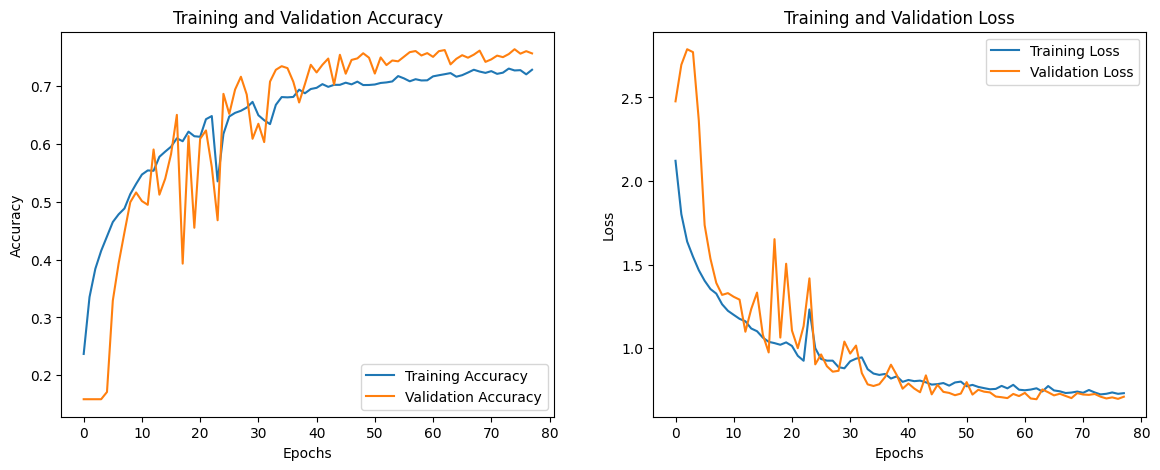

In [306]:
plot_training_history(classifier_fit)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


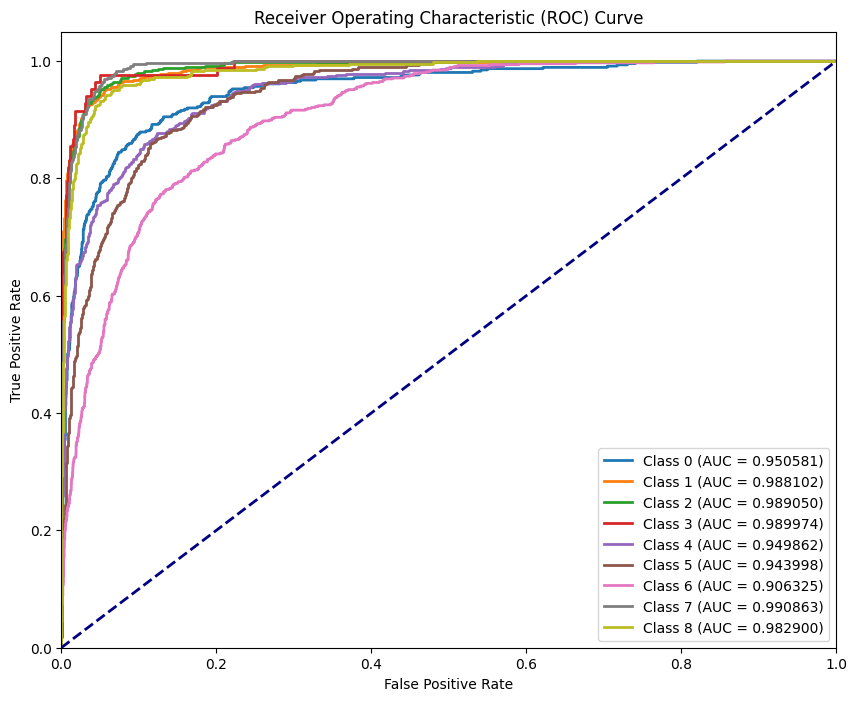

In [258]:
plot_roc_curve(X_test_std, y_test_enc, classifier_model)

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


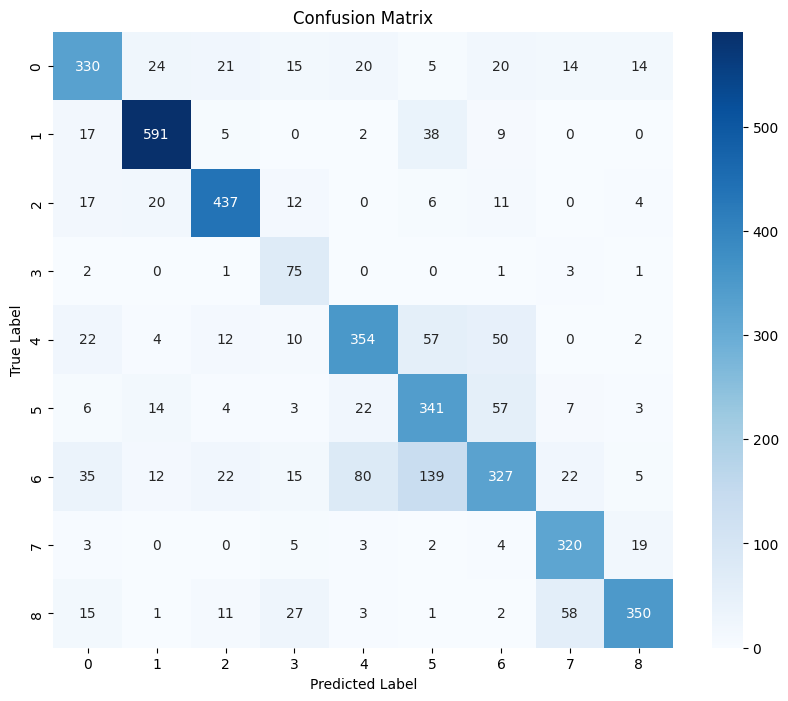

In [259]:
plot_confusion_matrix(X_test_std, y_test_enc, classifier_model)

## 3. Convolutional Autoencoder for anomaly detection

Steps:
- Train a convolutional autoencoder on **standard** train set only
- Plot training history
- Compute reconstruction loss (MSE) per image for:
  - Standard test set
  - Anomaly dataset (class 4)
- Plot histograms of reconstruction losses
- Use reconstruction loss as anomaly score and build ROC curve

In [275]:
# CAE model for standard dataset
cae_input = keras.Input((64, 64, 3))

# encoder

# first layer
x = layers.Conv2D(32, (3, 3), padding="same")(cae_input)
x = layers.BatchNormalization()(x)  # less dead neurons and vanaishing/exploding gradients
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)  # get some sharper edges (especially for small spiral galaxy arms)

# second layer
x = layers.Conv2D(16, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
encoder_output = layers.Flatten()(x)

# new representation space with bootleneck
x = layers.Dense(16*16*3)(encoder_output)
x = layers.Reshape((16, 16, 3))(x)

# decoder
# first decoder layer
x = layers.Conv2DTranspose(16, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)

# second decoder layer
x = layers.Conv2DTranspose(32, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)

cae_output = layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)

# compile the model
cae_model = keras.Model(cae_input, cae_output, name="cae")

# compile the model
cae_model.compile(optimizer="adamW", loss="mse", metrics=["accuracy"])

# model summary
print(cae_model.summary())

Model: "cae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_75 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_186 (Conv2D)             │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_247         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_201 (Activation)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_187 (Conv2D)             │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_248         │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_202 (Activation)     │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_178               │ (None, 16, 16, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_63 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 768)            │     3,146,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 16, 16, 16)     │           448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_249         │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_203 (Activation)     │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 32, 32, 32)     │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_250         │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_204 (Activation)     │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 64, 64, 3)      │           86

 Total params: 3,158,355 (12.05 MB)

 Trainable params: 3,158,163 (12.05 MB)

 Non-trainable params: 192 (768.00 B)

None


In [276]:
# Train model
cae_fit = cae_model.fit(
    X_train_std,
    X_train_std,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_std, X_val_std)
    )

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.3403 - loss: 0.0131 - val_accuracy: 0.3080 - val_loss: 0.0100
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3522 - loss: 0.0032 - val_accuracy: 0.3253 - val_loss: 0.0071
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3589 - loss: 0.0026 - val_accuracy: 0.3481 - val_loss: 0.0058
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3674 - loss: 0.0023 - val_accuracy: 0.3677 - val_loss: 0.0043
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3808 - loss: 0.0020 - val_accuracy: 0.3832 - val_loss: 0.0030
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3892 - loss: 0.0019 - val_accuracy: 0.3911 - val_loss: 0.0027
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3949 - loss: 0.0017 - val_accuracy: 0.3944 - val_loss: 0.0020
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3995 - loss: 0.0016 - val_acc

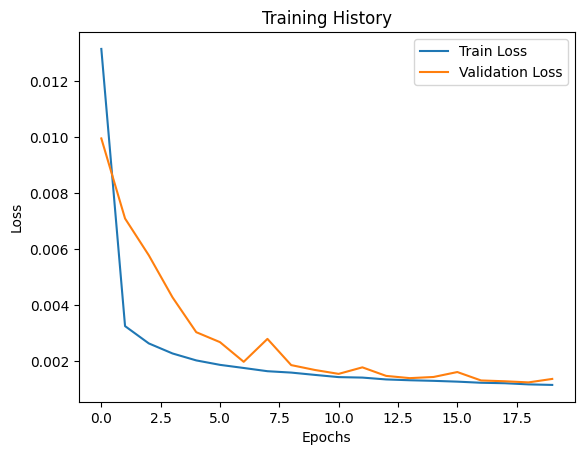

In [277]:
# plot training history
plt.plot(cae_fit.history['loss'], label='Train Loss')
plt.plot(cae_fit.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [278]:
# reconstruct some images
X_out_test = cae_model.predict(X_test_std)
X_out_anom = cae_model.predict(anom_images)

# calculate MSE
mse_test = np.mean(np.square(X_test_std - X_out_test), axis=(1, 2, 3))
mse_anom = np.mean(np.square(anom_images - X_out_anom), axis=(1, 2, 3))

print(f"\nReconstruction loss (MSE) test set: {mse_test}")
print(f"\nReconstruction loss (MSE) anomaly set: {mse_anom}")


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Reconstruction loss (MSE) test set: [0.00132777 0.00122392 0.00043772 ... 0.0016539  0.00166373 0.00137373]

Reconstruction loss (MSE) anomaly set: [0.00126278 0.00099516 0.00070294 ... 0.00075776 0.00174305 0.00140709]


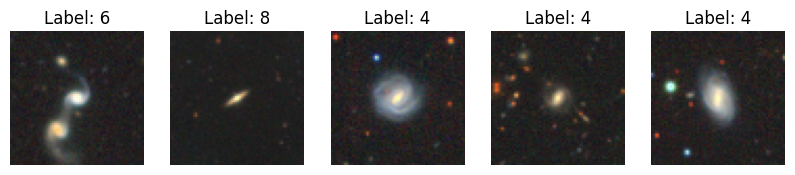

In [279]:
# Visualize data set galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_test_std[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

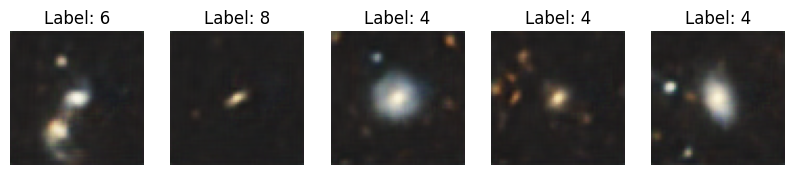

In [280]:
# Visualize reconstructed galaxies
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(X_out_test[digits[i]])
    ax.set_title(f"Label: {y_test_std[digits[i]]}")
    ax.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


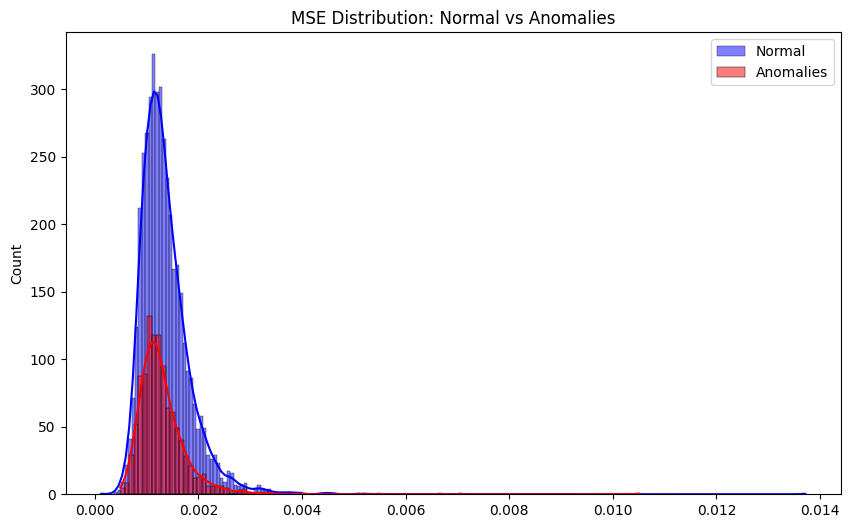

In [281]:
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_test, label='Normal', color='blue', kde=True)
sns.histplot(mse_anom, label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

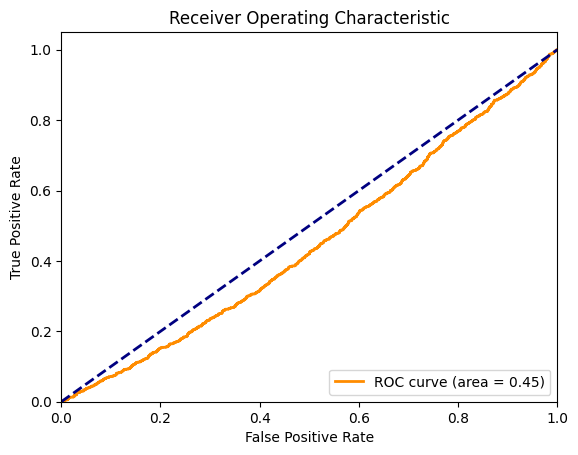

In [282]:
# ROC curve
# combine normal and anomaly dataset
mse_all = np.concatenate([mse_test, mse_anom])
y_all = np.concatenate([np.zeros(len(mse_test)), np.ones(len(mse_anom))])

# compute ROC curve
fpr, tpr, thresholds = roc_curve(y_all, mse_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## 4. Variational Autoencoder (VAE) on standard data

Steps:
- Build a VAE with convolutional encoder/decoder (trained on standard train set)
- Plot training history
- Generate new galaxy images from the VAE
- Visualize some generated images

In [ ]:
# Add Sampling class such that we have a possibility to differentiate in Training
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define Encoder and Decoder
latent_dim = 128
img_dim = (64, 64, 3)

# Encoder
encoder_inputs = keras.Input(shape=img_dim)
# first layer
x = layers.Conv2D(64, (3, 3), strides=1, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
# second layer
x = layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
# third layer
x = layers.Conv2D(128, (3, 3), strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
# fourth layer
x = layers.Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x)
# fifth layer
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)


# normal distribution space
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 256))(x)

# first layer 
x = layers.Conv2D(256, (3, 3), padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
# second decoder layer
x = layers.Conv2D(128, (3, 3), strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)
# third decoder layer
x = layers.Conv2D(128, (3, 3), strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)
# fourth decoder layer
x = layers.Conv2D(64, (3, 3), strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.UpSampling2D((2, 2))(x)
# fifth decoder layer
x = layers.Conv2D(64, (4, 4), activation="relu", padding="same")(x)
# sixth layer
x = layers.Conv2D(64, (4, 4), activation="relu", padding="same")(x)

decoder_outputs = layers.Conv2D(3, (3, 3), padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

# wichtig ohne batchnorm, 3. convtranspose 64, 5. convtranspose 32, mse und beta 0.25, 128 latent space dim, without 3xfifth layer mal was okeyes

In [ ]:
# VAE Class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_absolute_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
# construct the VAE model
vae = VAE(encoder, decoder, 0.009)   #0.61
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# training VAE model
vae_fit = vae.fit(X_train_std, epochs=50, batch_size=128)

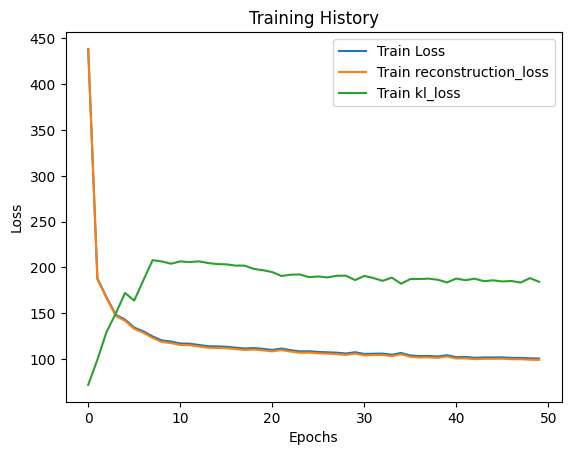

In [109]:
# plot training history
plt.plot(vae_fit.history['loss'], label='Train Loss')
plt.plot(vae_fit.history['reconstruction_loss'], label='Train reconstruction_loss')
plt.plot(vae_fit.history['kl_loss'], label='Train kl_loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def generate_random_images(decoder, latent_dim, n=10, rows=2):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    cols = int(np.ceil(n / rows))
    
    # Plot
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = generated[i].squeeze()
        plt.imshow(img)
        plt.axis("off")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


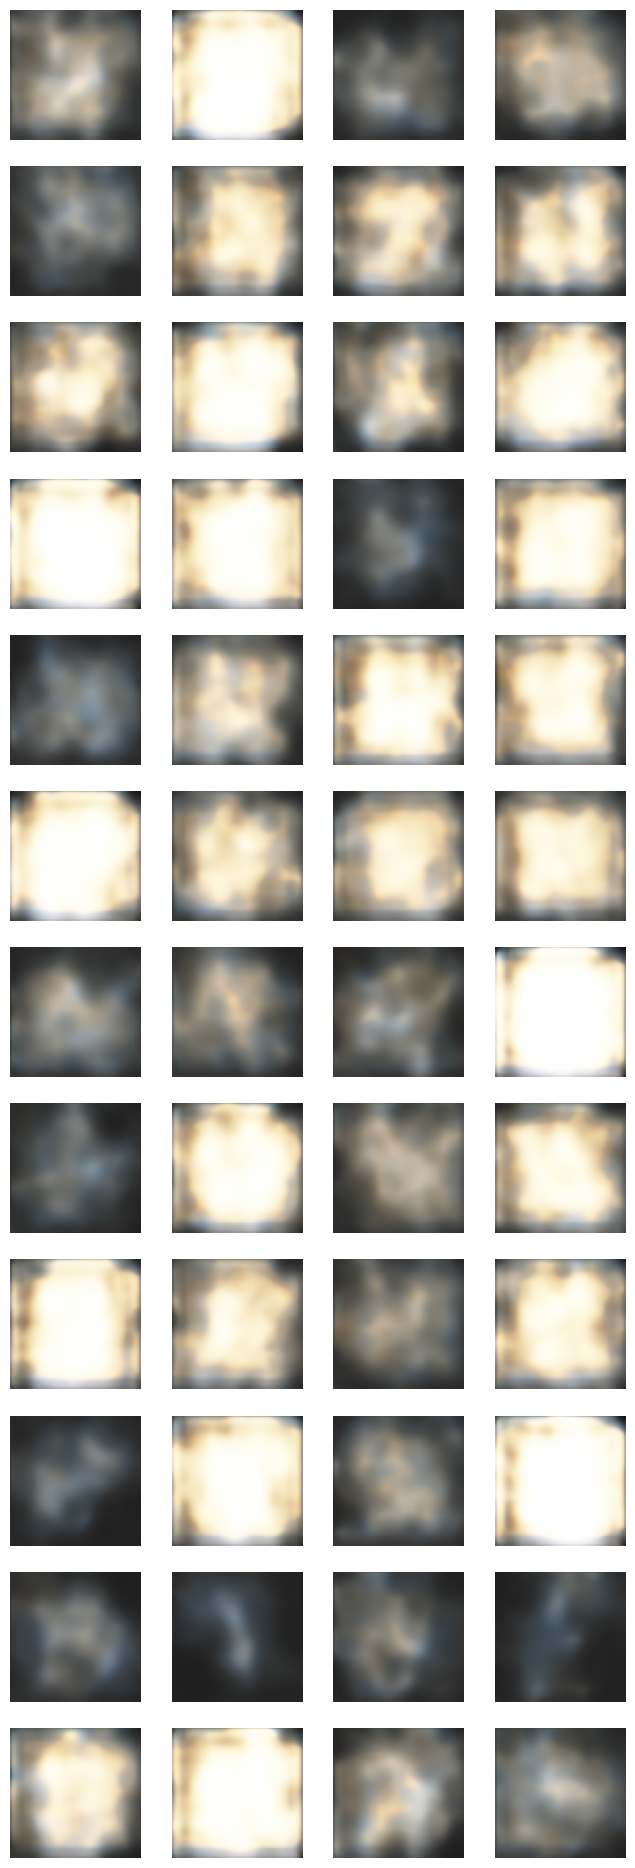

In [111]:
# generate and visualize generated galaxy images
generate_random_images(decoder, latent_dim=latent_dim, n=48, rows=12)